# EURONEXT LISBON - Forecasting with LSTM

### Preliminary Tasks

#### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
import os

#### Model Parameters

In [159]:
LOOK_BACK = 90
PERIODS_TO_PREDICT = 50
BATCH_SIZE = 32
EPOCHS=8
LEARN_RATE=0.0005
VALIDATION_SPLIT=0.1
NUMBER_NEURONS=50
PERIOD='5y'
NUMBER_OF_LAYERS=2;




In [4]:
# Foreign stock tickers and names
NAME_FOREIGN='IBEX 35'
TICKER_FOREIGN='^IBEX'

NAME_FOREIGN='NYSE'
TICKER_FOREIGN='^NYA'

NAME_FOREIGN='CAC 40'
TICKER_FOREIGN='^FCHI'





#### Loading data from Yahoo

In [5]:
#df = pd.DataFrame(yf.Ticker('PSI20.LS').history(period = PERIOD))
#df=df.truncate(after="2023-02-01")
#df.to_csv('stocks10y.csv')

In [6]:
#df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")
#df_other.to_csv('stocks'+PERIOD+NAME_FOREIGN+'.csv')

C:\Users\queir\AppData\Local\Temp\ipykernel_10988\3563341454.py:1: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  df_other = pd.DataFrame(yf.Ticker(TICKER_FOREIGN).history(period = PERIOD)).truncate(after="2023-02-01")


In [7]:
def load_df_other():
    return pd.read_csv('stocks'+PERIOD+NAME_FOREIGN+'.csv', index_col=0, parse_dates=True)


In [8]:
def load_df_portugal():
    return pd.read_csv('stocks.csv', index_col=0, parse_dates=True) if PERIOD=='5y' else pd.read_csv('stocks10y.csv', index_col=0, parse_dates=True)    

In [53]:
def load_multiple_index(end_date="2023-02-01") : 
    
    from datetime import date, timedelta

    # Load DFs
    df_other = load_df_other()
    df = load_df_portugal()


    # Truncate Data for different period analysis
    end_date=end_date + ' 00:00:00+00:00'
    df=df.truncate(after=pd.Timestamp(end_date))
    df_other=df_other.truncate(after=pd.Timestamp(end_date))


    #Correct Index so both tables have simple date format as index
    df_other.index = pd.to_datetime(df_other.index, utc=True).date + timedelta(days=1)
    df.index = pd.to_datetime(df.index + timedelta(hours=1), utc=True).date

    # get common indices
    common_indices = df.index.intersection(df_other.index)

    # select only rows with common indices
    df = df.loc[common_indices]
    df_other = df_other.loc[common_indices]

    return df, df_other

In [9]:
#df = pd.read_csv('stocks.csv', index_col=0, parse_dates=True)
df = pd.read_csv('stocks.csv', index_col=0, parse_dates=True)


In [10]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-06 00:00:00+01:00,5462.390137,5464.299805,5407.589844,5417.060059,58771500,0,0
2018-04-09 00:00:00+01:00,5492.680176,5507.770020,5444.040039,5448.990234,54414200,0,0
2018-04-10 00:00:00+01:00,5458.560059,5482.720215,5443.790039,5475.839844,47036700,0,0
2018-04-11 00:00:00+01:00,5464.990234,5505.879883,5462.930176,5465.709961,46407600,0,0
2018-04-12 00:00:00+01:00,5460.149902,5494.180176,5442.240234,5487.540039,73885100,0,0
...,...,...,...,...,...,...,...
2023-01-26 00:00:00+00:00,5923.089844,5976.750000,5917.790039,5961.770020,127496000,0,0
2023-01-27 00:00:00+00:00,5954.439941,5956.859863,5925.200195,5936.729980,69082900,0,0
2023-01-30 00:00:00+00:00,5908.270020,5917.919922,5873.939941,5876.200195,66985300,0,0


### EDA - Exploratory Data Analysis

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

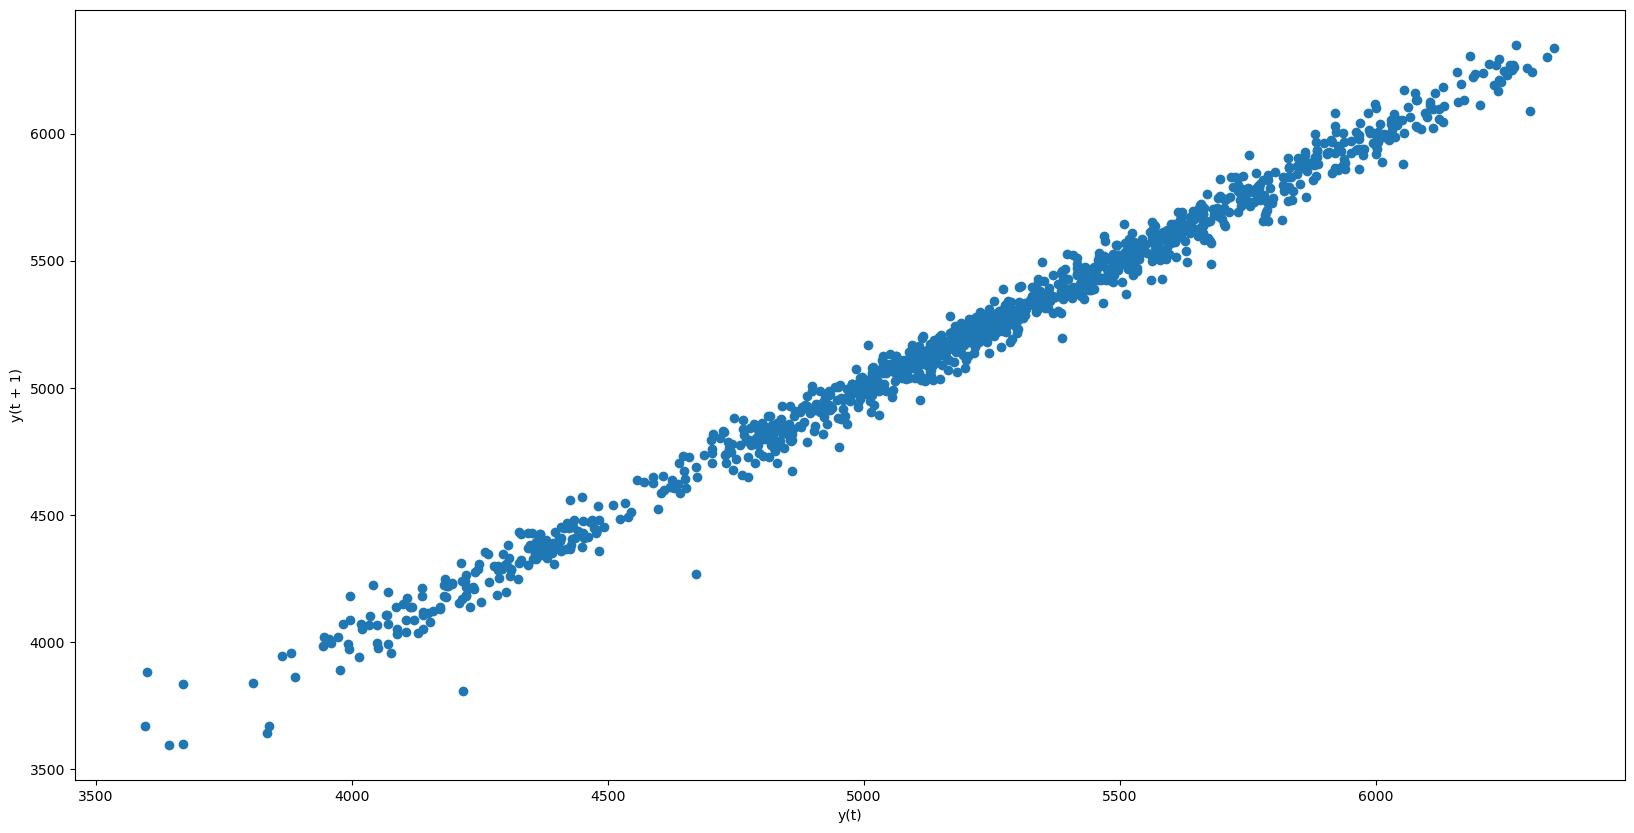

In [11]:
from pandas.plotting import lag_plot
lag_plot(df['Close'])

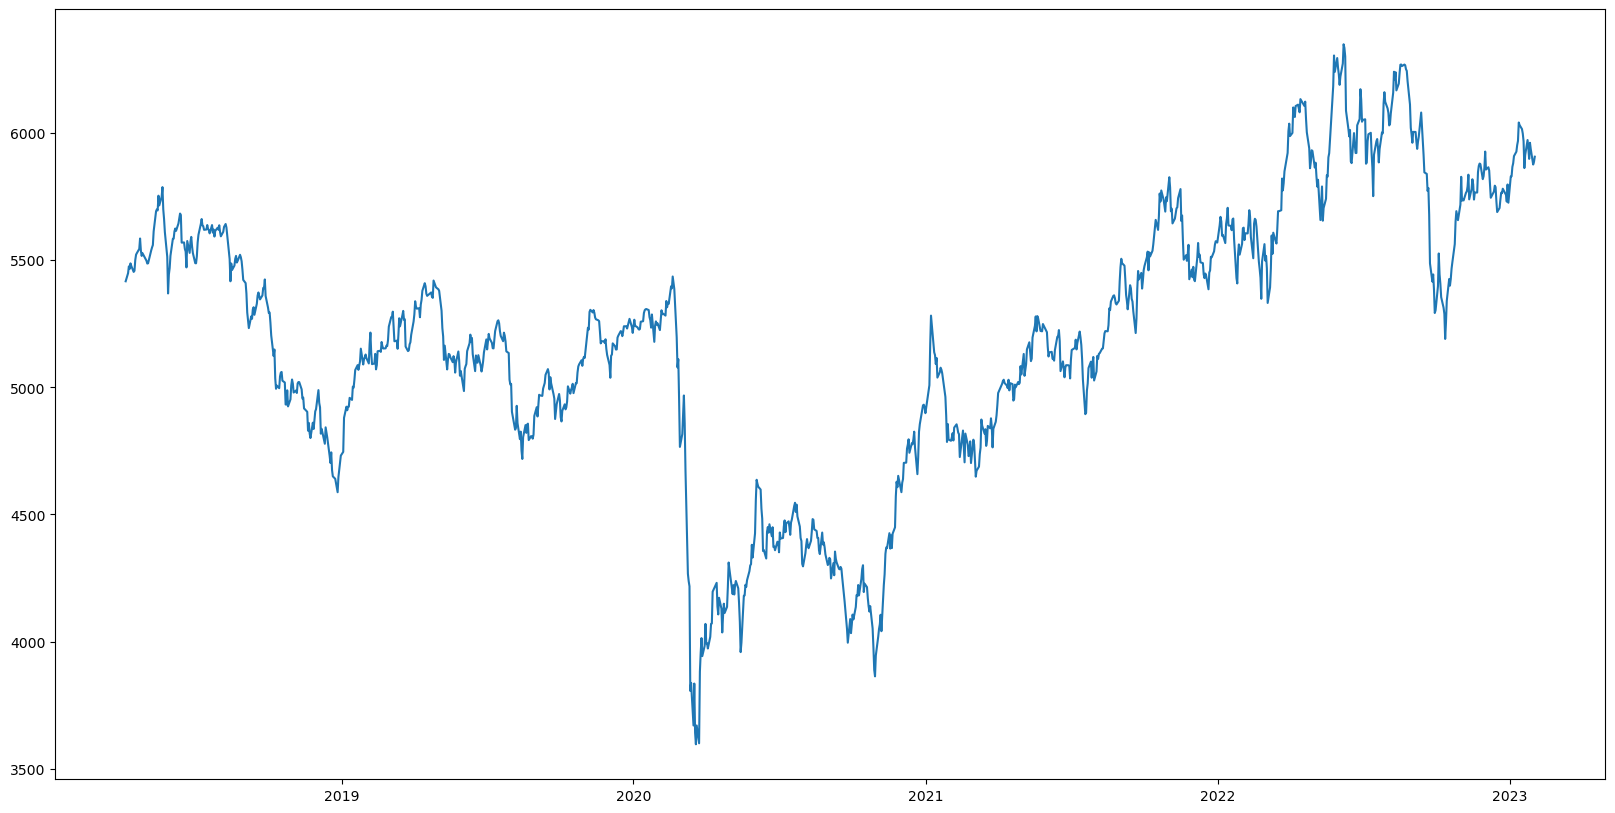

In [12]:
plt.plot(df['Close'])

In [13]:
df.describe()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1228.000000,1228.000000,1228.000000,1228.000000,1.228000e+03,1228.0,1228.0
mean,5197.101938,5227.978416,5164.300575,5195.969664,8.011948e+07,0.0,0.0
std,540.078839,539.456283,541.184158,541.032964,4.245179e+07,0.0,0.0
min,3554.699951,3613.669922,3500.020020,3596.080078,6.284000e+05,0.0,0.0
25%,4902.504883,4933.772583,4877.552368,4903.747314,5.143135e+07,0.0,0.0
50%,5218.574951,5240.354980,5191.094971,5219.030029,6.804180e+07,0.0,0.0
75%,5586.112549,5614.227417,5553.397461,5583.119873,9.607812e+07,0.0,0.0
max,6362.879883,6370.779785,6314.640137,6349.209961,3.252189e+08,0.0,0.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 2018-04-06 00:00:00+01:00 to 2023-02-01 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1228 non-null   float64
 1   High          1228 non-null   float64
 2   Low           1228 non-null   float64
 3   Close         1228 non-null   float64
 4   Volume        1228 non-null   int64  
 5   Dividends     1228 non-null   int64  
 6   Stock Splits  1228 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 76.8+ KB


### Setting the Model

##### Data Preparation

In [15]:
#Dropping unwanted columns
def selectData(type='univariate', datframe=df) :
    if type=='univariate' :
        data = datframe.drop(columns=['Open', 'High', 'Low','Volume','Dividends','Stock Splits'])
    else :
        data = datframe.drop(columns=['Open', 'High', 'Low','Dividends','Stock Splits'])
    size = len(data) - PERIODS_TO_PREDICT
    return data, size

In [16]:
# Divides Data into Train Data and Test Data
def divideData(data, size) : 
    train_data=data.values[0:size,:]
    test_data=data.values[size:,:]
    return train_data,test_data

In [17]:
# Scale Data between 0 and 1 
def scaleData(data,*scaler) :
    if len(scaler) == 1 :
        return scaler[0].fit_transform(data)
    else: 
        a1=scaler[0].fit_transform(data[:,0].reshape(-1,1))
        a2=scaler[1].fit_transform(data[:,1].reshape(-1,1))    
        scaled_data = np.array([a1,a2]).squeeze()
    return np.transpose(scaled_data)

In [18]:
def diffLogData (data) : 
    
    data = np.reshape(data,(1, data.size))
    return np.diff(np.log(data)).T
    #return np.transpose(np.diff(np.log(data)))

In [19]:
#%% Creates a vectors for training (2D numpy arrays)
def createTrainVector(data, size) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    x_train=[]

    for i in range(LOOK_BACK,size):
        x_train.append(data[i-LOOK_BACK:i,0])
    
    return np.asarray(x_train)

In [20]:
def createBivTrainVector(data, size) :
    x0, x1 = [],[]
    for i in range(LOOK_BACK,size):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    x_data = np.array([np.asarray(x0),np.asarray(x1)]) 
    return  np.reshape(x_data,(x_data.shape[1],x_data.shape[2],x_data.shape[0]))
   

In [21]:
#%% Creates a vectors with target data
def createTargetVector(data) :
    return np.asarray(data[LOOK_BACK:])

In [22]:
#%% Creates a vectors with target data
from keras.utils import to_categorical
def createTargetClassVector(data, numCat=5) :
    data = data[LOOK_BACK:]
    percentiles = []
    y_data = []

    # Calculate Percentiles
    for i in range(0,numCat) :
            percentiles.append(np.percentile(data, (100/numCat)*i))
            
            
    # fill the vector with a classification number from 0 to [numCat]
    for i in range(0,len(data)):
        for j in reversed(range(0,numCat)) :
            if(data[i]>=percentiles[j]):
                y_data.append(j)
                break
                

    from keras.utils import to_categorical       
    #one hot encode the vector 
    return np.asarray(to_categorical(y_data, num_classes=len(np.unique(y_data))))
    


In [23]:
# CREATES a VECTOR FOR TEST WITH LENGTH = PERIODS_TO_PREDICT + LOOK_BACK
def selectTestData (data, size):
    test_data=data[size-LOOK_BACK:].values
    return test_data.reshape(-1,1)
    

In [24]:
# Creates an array for predicting PERIODS_TO_PREDICT
def createTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    X_test=[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        X_test.append(data[i-LOOK_BACK:i,0])
    X_test=np.array(X_test)

    #Reshaopes the vector for the predict function
    return np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [25]:
def createBivTestVector(data) :
    "For each predicted result creates a vector with x values, wher x is the LOOK_BACK"

    x0,x1=[],[]
    
    for i in range(LOOK_BACK,data.shape[0]):
        x0.append(data[i-LOOK_BACK:i,0])
        x1.append(data[i-LOOK_BACK:i,1])
    
    X_test=np.array([np.array(x0),np.array(x1)])
    return np.reshape(X_test, (X_test.shape[1],X_test.shape[2],X_test.shape[0]))

#### LSTM Model

In [41]:
#%% Creates a LSTM Sequential model
def createLstmModel (data,outputs=1) : 

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
    try:
        numSources = data.shape[2]
    except:
        numSources = 1
    

    input_shape=(np.shape(data)[1],numSources)
    lstm_model=Sequential()

    if (NUMBER_OF_LAYERS==1):
        lstm_model.add(LSTM(units=NUMBER_NEURONS, input_shape=input_shape))
    else:
        if(NUMBER_OF_LAYERS==2):
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2)))
        else:
            lstm_model.add(LSTM(units=NUMBER_NEURONS, return_sequences=True, input_shape=input_shape))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/2),return_sequences=True))
            lstm_model.add(LSTM(units=int(NUMBER_NEURONS/4)))

    #lstm_model.add(Dropout(0.01))
    # For single output (regression)
    if (outputs == 1) : 
        lstm_model.add(Dense(units=outputs))
        lstm_model.compile(loss='mse',
                    optimizer=Adam(learning_rate=LEARN_RATE)
                    )
    
    #For Multiple outputs (Category/Calssification)
    elif (outputs > 1) : 
        lstm_model.add(Dense(units=outputs, activation = 'softmax'))
        
        lstm_model.compile(loss='categorical_crossentropy',
                   metrics=['accuracy'],
                   optimizer=Adam(learning_rate=LEARN_RATE)
                   )
    return lstm_model

In [27]:
#%% Trains the model -  data
def trainLstmModel (model, x_train, y_train) :
    return model.fit(x_train,
                y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_split=VALIDATION_SPLIT,
                verbose='auto')

In [28]:
def plotHistory(history, yaxis="MAE", title="") :
    plt.plot(history.history['loss'], label='Train Data')
    plt.plot(history.history['val_loss'], label='Validation Data')
    plt.xlabel("EPOCHS")
    plt.ylabel(yaxis)
    plt.title(title, fontsize=20)
    plt.legend()
    plt.show()

# RUNNING THE MODEL

#### Linear Univariate model

This model gives an estimate the PSI-20 value  based on the quotations of a sliding window of the [LOOK_BACK] days, before the estimated value.

In [29]:
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler)
x_train_data = createTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data)

test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler)
X_test = createTestVector(scaled_test_data)

In [30]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.66142175 0.67301952 0.68277192 ... 0.74325226 0.73825795 0.70506295]
 [0.67301952 0.68277192 0.67909251 ... 0.73825795 0.70506295 0.69318194]
 [0.68277192 0.67909251 0.6870217  ... 0.70506295 0.69318194 0.66141802]
 ...
 [0.84216508 0.86140135 0.86464127 ... 0.80715397 0.79970062 0.77815803]
 [0.86140135 0.86464127 0.85155443 ... 0.79970062 0.77815803 0.78817202]
 [0.86464127 0.85155443 0.83123576 ... 0.77815803 0.78817202 0.78821565]]

y data - target

[[0.69318194]
 [0.66141802]
 [0.68682554]
 ...
 [0.78817202]
 [0.78821565]
 [0.8174441 ]]


In [31]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
31/31 [==============================] - 5s 74ms/step - loss: 0.0824 - val_loss: 0.0185
Epoch 2/10
31/31 [==============================] - 2s 50ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 3/10
31/31 [==============================] - 2s 50ms/step - loss: 0.0053 - val_loss: 0.0077
Epoch 4/10
31/

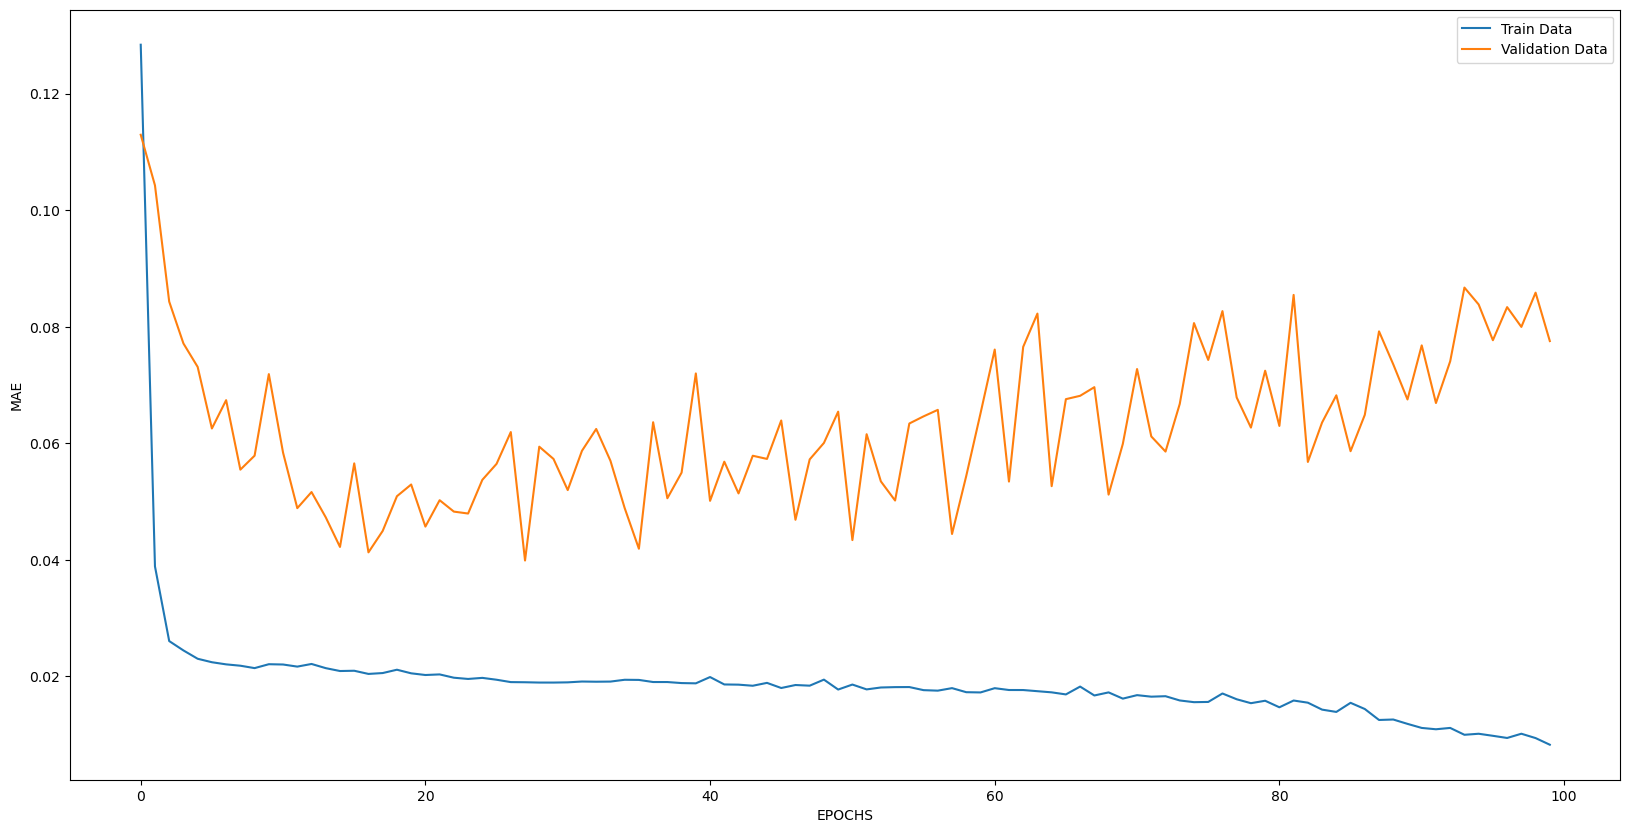

In [128]:
plotHistory(history)

#### Bivariate Model

In addition to the univariate method (above) This model also considers the volume of trading during the [LOOK_BACK] days before, to estimate the value of the index. 

In [160]:

global_data, size_train_data = selectData(type='bivariate') 
train_data,test_data = divideData(global_data, size_train_data)
scaler=MinMaxScaler(feature_range=(0,1))
scaler2=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler,scaler2)
x_train_data = createBivTrainVector(scaled_train_data, size_train_data)
y_train_data = createTargetVector(scaled_train_data[:,0])
test_data=global_data[size_train_data-LOOK_BACK:].values


scaled_test_data=scaleData(test_data,scaler,scaler2)
X_test = createBivTestVector(scaled_test_data)


In [161]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[[0.66142175 0.67301952]
  [0.68277192 0.67909251]
  [0.6870217  0.68340401]
  ...
  [0.7391261  0.74104012]
  [0.74325226 0.73825795]
  [0.70506295 0.69318194]]

 [[0.68277192 0.67909251]
  [0.6870217  0.68340401]
  [0.67482836 0.67640097]
  ...
  [0.74325226 0.73825795]
  [0.70506295 0.69318194]
  [0.66141802 0.68682554]]

 [[0.6870217  0.68340401]
  [0.67482836 0.67640097]
  [0.69183795 0.69950199]
  ...
  [0.70506295 0.69318194]
  [0.66141802 0.68682554]
  [0.67749064 0.68383977]]

 ...

 [[0.47680046 0.50193644]
  [0.26089088 0.36386247]
  [0.38219172 0.30379262]
  ...
  [0.17215199 0.18506149]
  [0.21018853 0.37070155]
  [0.41073661 0.42877965]]

 [[0.26089088 0.36386247]
  [0.38219172 0.30379262]
  [0.32942184 0.39073879]
  ...
  [0.21018853 0.37070155]
  [0.41073661 0.42877965]
  [0.46205665 0.34610378]]

 [[0.38219172 0.30379262]
  [0.32942184 0.39073879]
  [0.23015061 0.21711326]
  ...
  [0.41073661 0.42877965]
  [0.46205665 0.34610378]
  [0.20667179 0.14928194]]]

y

In [162]:

lstm_biv_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_biv_model, x_train_data, y_train_data)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 90, 50)            10600     
                                                                 
 lstm_11 (LSTM)              (None, 25)                7600      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
31/31 [==============================] - 5s 76ms/step - loss: 0.1290 - val_loss: 0.1399
Epoch 2/8
31/31 [==============================] - 2s 53ms/step - loss: 0.0504 - val_loss: 0.1099
Epoch 3/8
31/31 [==============================] - 2s 53ms/step - loss: 0.0282 - val_loss: 0.0861
Epoch 4/8
31/31

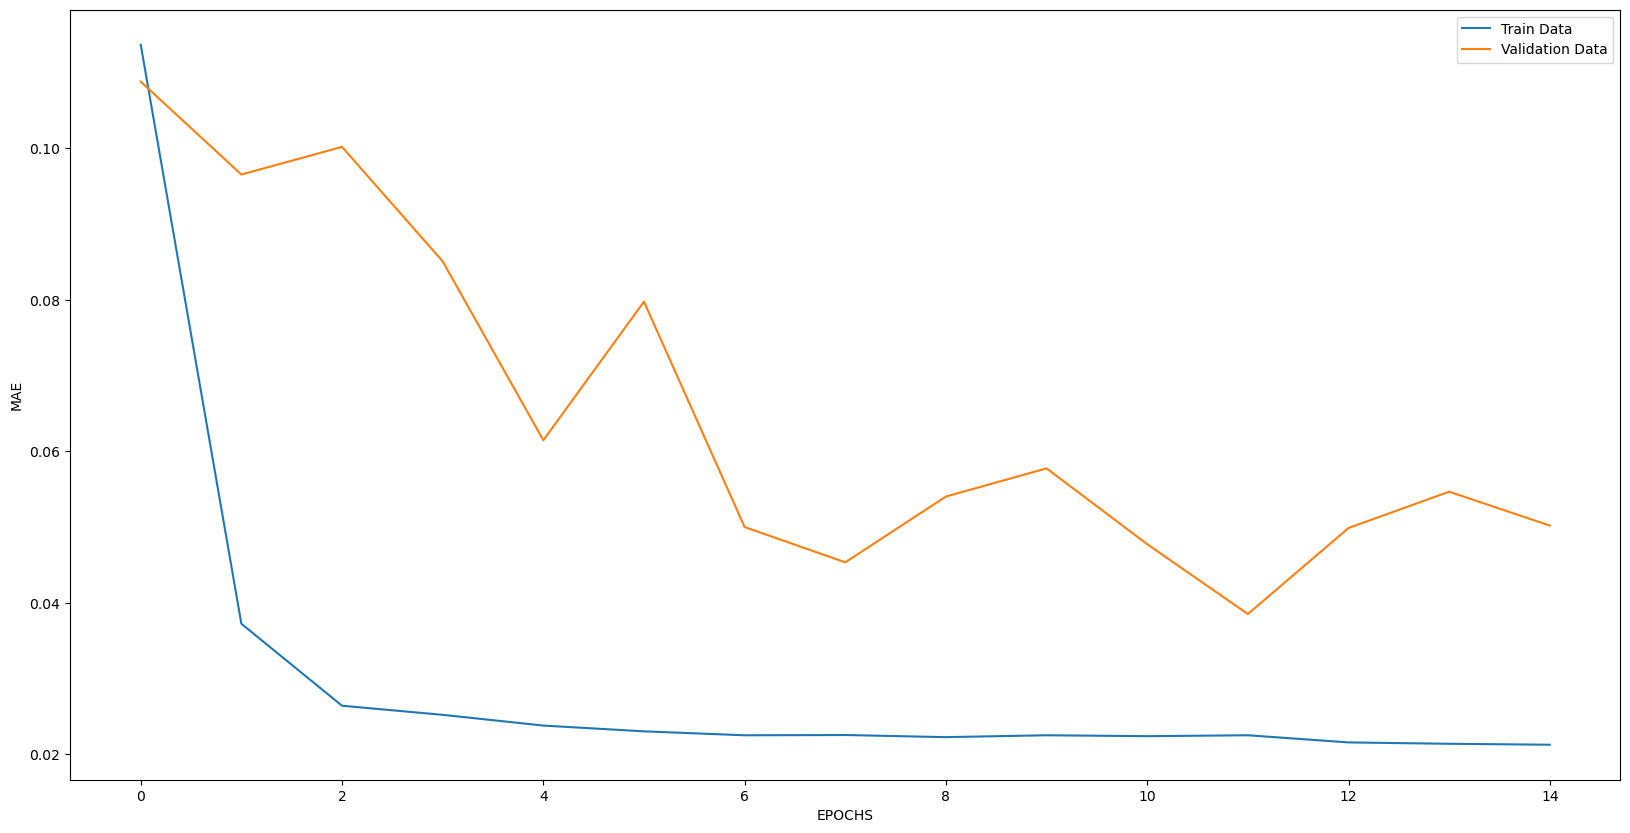

In [155]:

plotHistory(history)

#### Diff(log) model

This model works in similar way as the Linear univariate model. The difference is that the data is based on the difference of the logaritms between two consecutive days, providing insights on the daily variation in relation to the previous day.

In [ ]:
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
scaled_train_data=diffLogData(train_data)
x_train_data = createTrainVector(scaled_train_data, size_train_data)
x_train_data = x_train_data = x_train_data[:-1]
y_train_data = createTargetVector(scaled_train_data)
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=diffLogData(test_data)
X_test = createTestVector(scaled_test_data)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 50)            10600     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
31/31 [==============================] - 5s 77ms/step - loss: 0.1319 - val_loss: 0.1336
Epoch 2/200
31/31 [==============================] - 2s 51ms/step - loss: 0.0443 - val_loss: 0.0962
Epoch 3/200
31/31 [==============================] - 2s 50ms/step - loss: 0.0262 - val_loss: 0.1095
Epoch 4/2

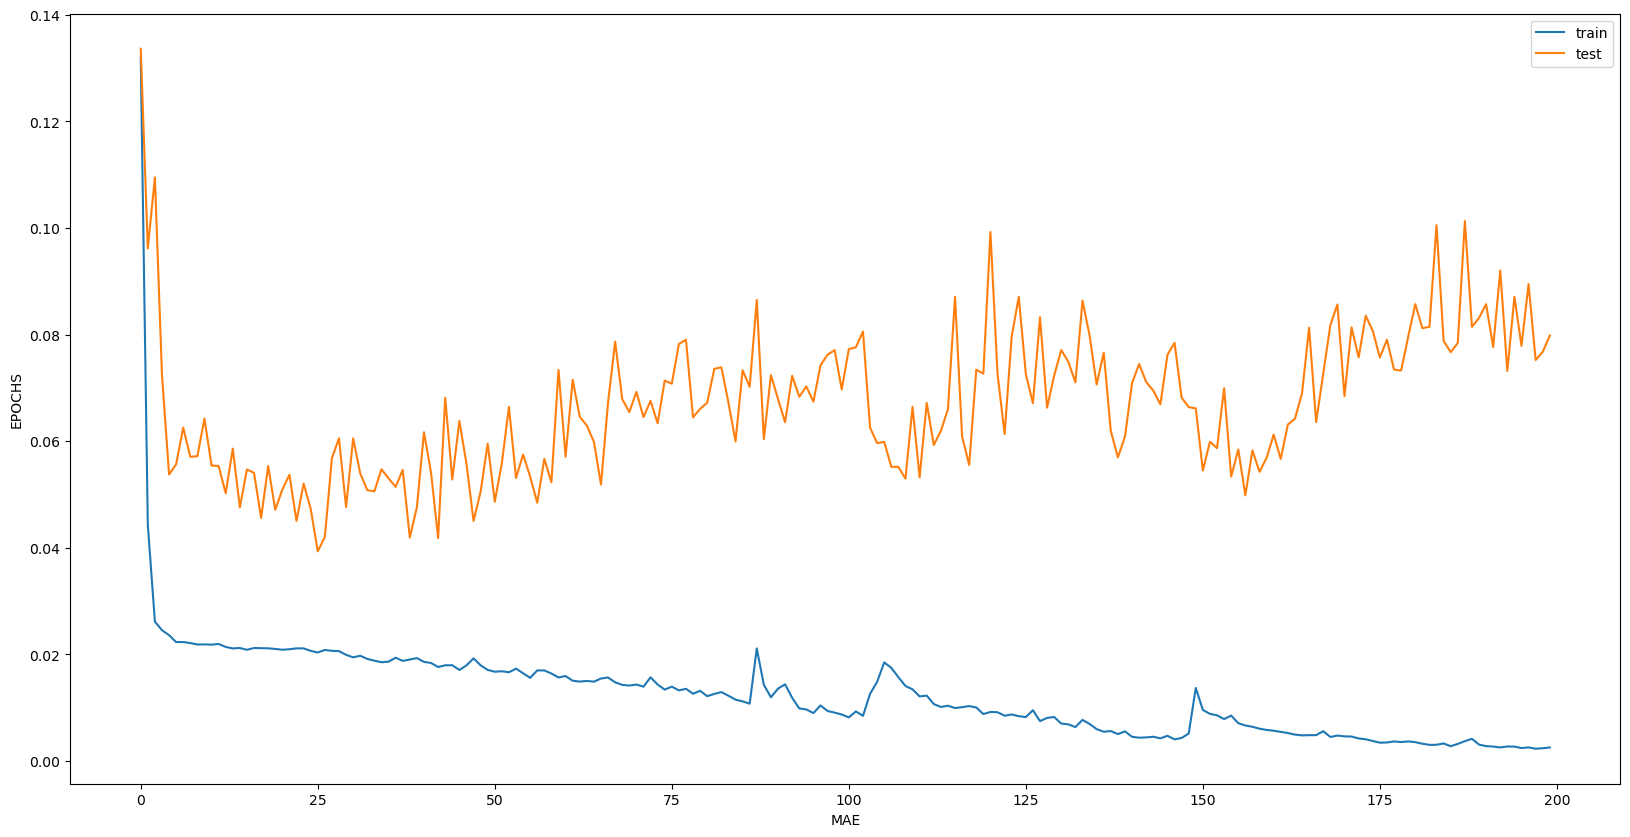

In [58]:
lstm_difflog_model = createLstmModel(x_train_data)
print(lstm_biv_model.summary())
history=trainLstmModel(lstm_difflog_model, x_train_data, y_train_data)      


In [ ]:
                        
plotHistory(history)

#### Classification Model (based on Diff(log) model)

##### This model classifies the forecast into n different categories

In [122]:
#df=df.truncate(after=pd.Timestamp('2022-02-01 00:00:00+00:00'))
global_data, size_train_data = selectData(type='univariate') 
train_data,test_data = divideData(global_data, size_train_data)
#instead of scaled between 0 and 1, the data is "difflogged"
difflogged_train_data=diffLogData(train_data)

#Number of CAtegories to classify the data
numCat=3

# Preparing the arrays for the model
x_train_data = createTrainVector(difflogged_train_data, size_train_data)
x_train_data = x_train_data[:-1]
y_train_data = createTargetClassVector(difflogged_train_data, numCat)


# Preparing Test Data
test_data=selectTestData(global_data,size_train_data)
difflogged_test_data=diffLogData(test_data)
X_test = createTestVector(difflogged_test_data)
Y_test = createTargetClassVector(difflogged_test_data, numCat)




In [131]:
#Show how many observations are in each percentile

numCat=y_train_data.shape[1]
for i in range(0, numCat):
    print('percentile ' + str(i*int(100/numCat)) + ' = ' + str(np.count_nonzero(y_train_data[:,i] == 1)))


percentile 0 = 782
percentile 33 = 782
percentile 66 = 782


In [124]:
lstm_class_model = createLstmModel(x_train_data, y_train_data.shape[1])
print(lstm_class_model.summary())
print(len(x_train_data))
print("number of Epochs " + str(EPOCHS))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 90, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 18,078
Trainable params: 18,078
Non-trainable params: 0
_________________________________________________________________
None
2346
number of Epochs 200


In [125]:

history = trainLstmModel(lstm_class_model, x_train_data, y_train_data)


Epoch 1/200
66/66 [==============================] - 6s 61ms/step - loss: 1.0990 - accuracy: 0.3250 - val_loss: 1.0996 - val_accuracy: 0.2638
Epoch 2/200
66/66 [==============================] - 3s 51ms/step - loss: 1.0988 - accuracy: 0.3401 - val_loss: 1.0999 - val_accuracy: 0.2638
Epoch 3/200
66/66 [==============================] - 3s 51ms/step - loss: 1.0986 - accuracy: 0.3411 - val_loss: 1.1010 - val_accuracy: 0.2638
Epoch 4/200
66/66 [==============================] - 3s 49ms/step - loss: 1.0986 - accuracy: 0.3415 - val_loss: 1.1004 - val_accuracy: 0.2638
Epoch 5/200
66/66 [==============================] - 3s 50ms/step - loss: 1.0986 - accuracy: 0.3415 - val_loss: 1.0997 - val_accuracy: 0.2638
Epoch 6/200
66/66 [==============================] - 3s 51ms/step - loss: 1.0986 - accuracy: 0.3430 - val_loss: 1.1017 - val_accuracy: 0.2638
Epoch 7/200
66/66 [==============================] - 3s 50ms/step - loss: 1.0988 - accuracy: 0.3311 - val_loss: 1.1012 - val_accuracy: 0.2638
Epoch 

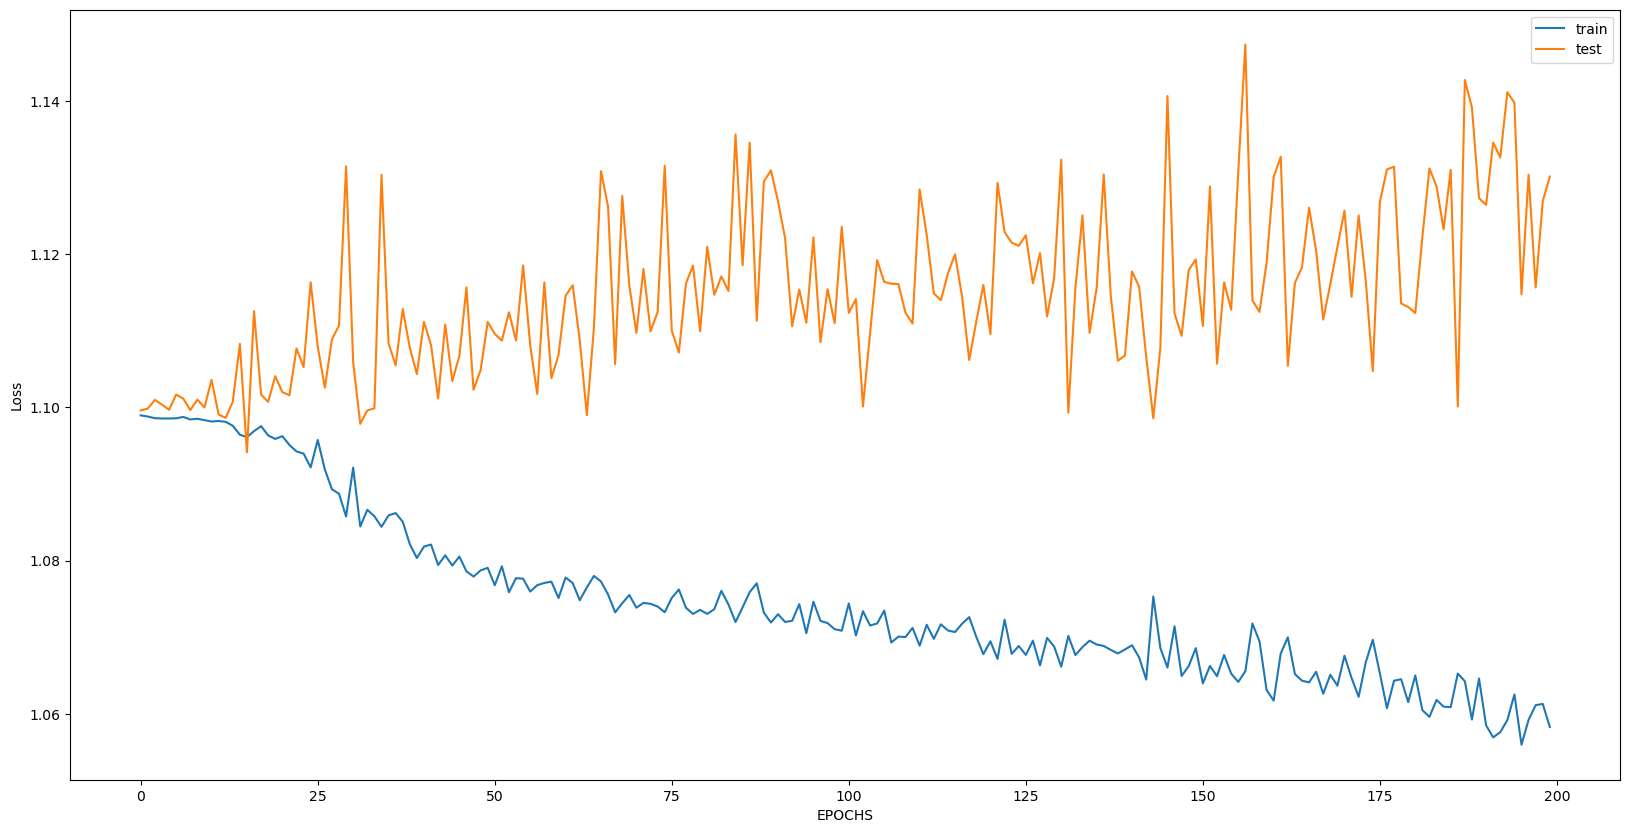

In [126]:
plotHistory(history, yaxis="Loss")

## Linear Model with foreign X_Data

#### This model predicts the PSI-20 index based on the information from the last 90 days of another stock exchange

In [58]:
df, df_other = load_multiple_index(end_date="2022-08-01")
df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
2018-05-04,5493.379883,5511.290039,5485.919922,5487.790039,57870500,0,0
2018-05-07,5513.689941,5531.500000,5506.319824,5527.759766,59076900,0,0
2018-05-08,5510.660156,5539.560059,5480.609863,5539.560059,116329700,0,0
2018-05-09,5557.060059,5568.930176,5542.729980,5550.390137,89739500,0,0
2018-05-10,5569.100098,5576.879883,5533.459961,5559.620117,62554800,0,0
...,...,...,...,...,...,...,...
2022-07-26,6020.549805,6048.160156,5998.979980,5998.979980,88841300,0,0
2022-07-27,6052.080078,6116.770020,6022.500000,6116.720215,130040900,0,0
2022-07-28,6159.060059,6211.040039,6092.839844,6160.720215,144036400,0,0
2022-07-29,6160.759766,6215.740234,6091.399902,6123.229980,107436700,0,0


In [59]:
df_other

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2018-05-04,5495.709961,5516.049805,5485.990234,5516.049805,85333000,0,0
2018-05-07,5511.939941,5532.120117,5503.700195,5531.419922,45591900,0,0
2018-05-08,5523.910156,5529.149902,5496.390137,5521.930176,70214400,0,0
2018-05-09,5520.649902,5535.240234,5511.580078,5534.629883,72894200,0,0
2018-05-10,5532.370117,5547.200195,5522.910156,5545.950195,48972800,0,0
...,...,...,...,...,...,...,...
2022-07-26,6225.169922,6243.859863,6194.959961,6211.450195,60556300,0,0
2022-07-27,6206.250000,6267.799805,6199.930176,6257.939941,69640600,0,0
2022-07-28,6304.129883,6339.209961,6236.569824,6339.209961,92169500,0,0
2022-07-29,6413.100098,6472.270020,6397.910156,6448.500000,103116600,0,0


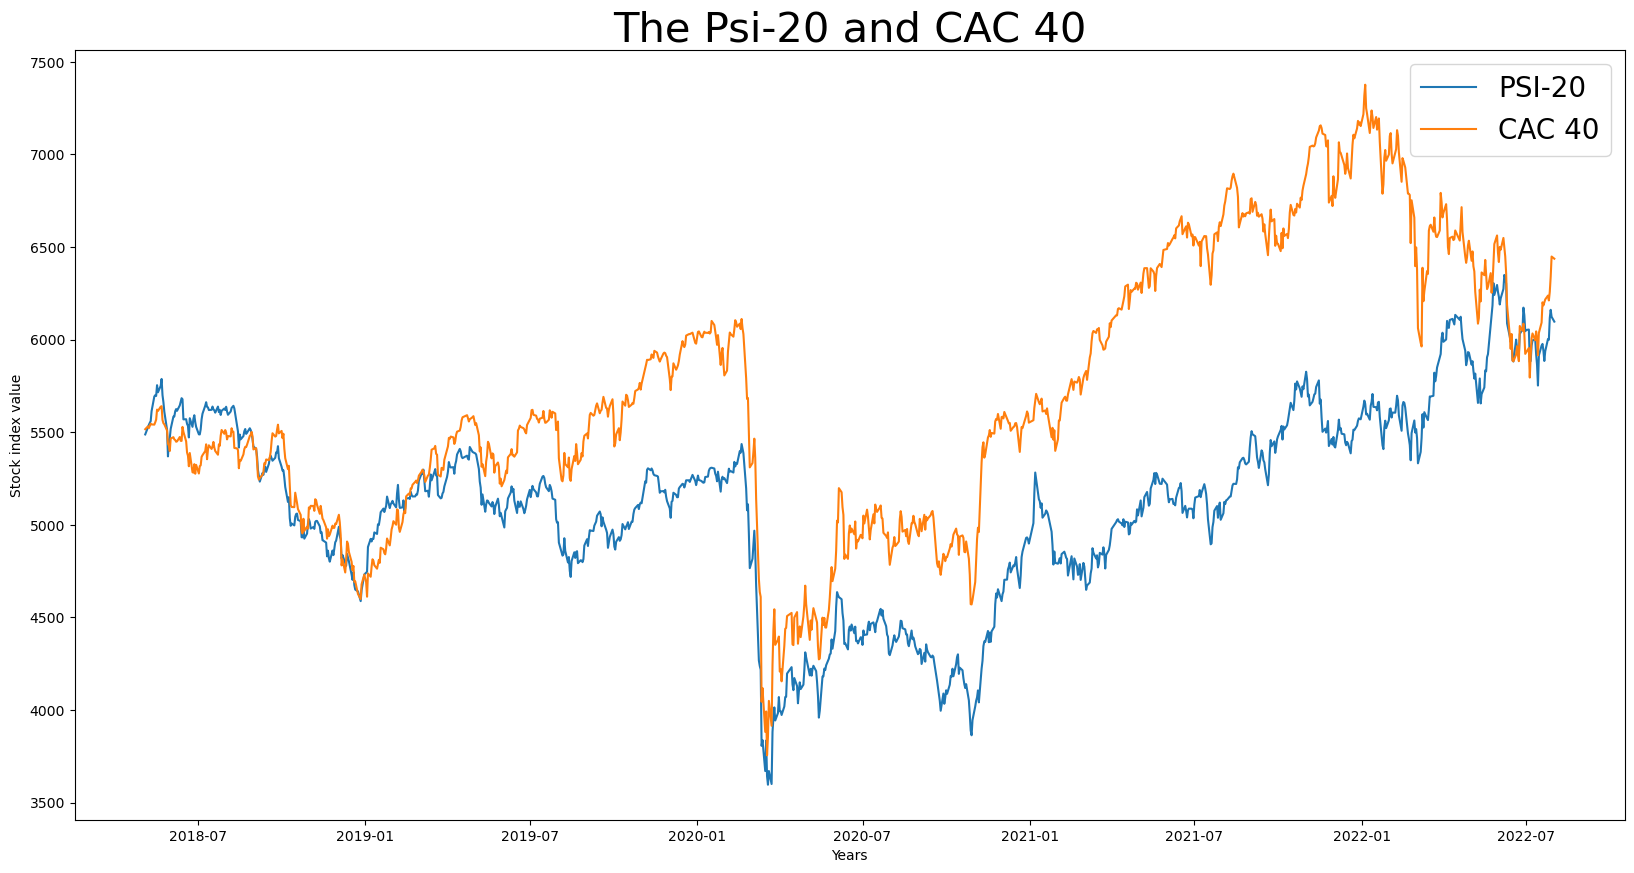

In [32]:
plt.plot(df['Close'], label='PSI-20')
plt.plot(df_other['Close'], label=NAME_FOREIGN)
plt.xlabel("Years")
plt.ylabel("Stock index value")
plt.title("The Psi-20 and "+NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [34]:
# Cleans unwanted columns leaving only index and close value
global_data, size_train_data = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data,test_data = divideData(global_data, size_train_data)

#Scales the data
scaler_f=MinMaxScaler(feature_range=(0,1))
scaled_train_data=scaleData(train_data,scaler_f)

#Create the vector for X_train_data
x_train_data = createTrainVector(scaled_train_data, size_train_data)

In [36]:
# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaler_p=MinMaxScaler(feature_range=(0,1))
scaled_train_data_p=scaleData(train_data_p,scaler_p)

#Create the vector for Y_train_data 
y_train_data = createTargetVector(scaled_train_data_p)

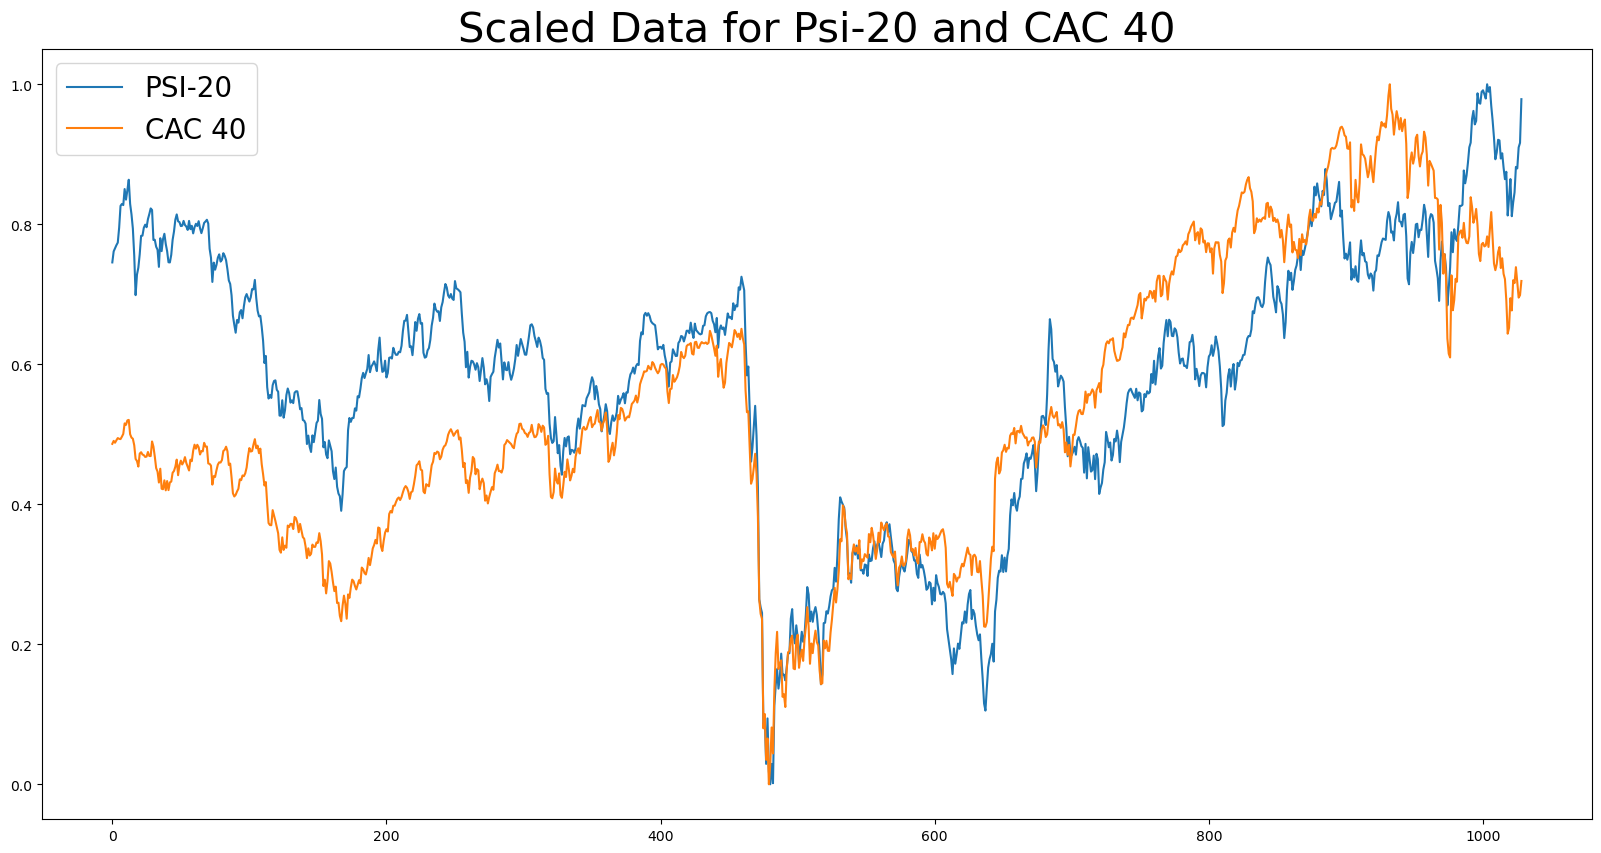

In [40]:
plt.plot(scaled_train_data_p, label='PSI-20')
plt.plot(scaled_train_data, label=NAME_FOREIGN)
#plt.plot(y_train_data, label='y_target')
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.title("Scaled Data for Psi-20 and "+ NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()

In [88]:
#Preaparing the X_test matrix
test_data=selectTestData(global_data,size_train_data)
scaled_test_data=scaleData(test_data,scaler_f)
X_test = createTestVector(scaled_test_data)

In [89]:
print("x data\n")
print(x_train_data)
print("\ny data - target\n")
print(y_train_data)

x data

[[0.48631647 0.49056057 0.4879402  ... 0.43845007 0.41567517 0.41115212]
 [0.49056057 0.4879402  0.49144692 ... 0.41567517 0.41115212 0.41346616]
 [0.4879402  0.49144692 0.49457276 ... 0.41115212 0.41346616 0.41827343]
 ...
 [0.9467103  0.96156868 0.95161438 ... 0.71597637 0.73873469 0.71740392]
 [0.96156868 0.95161438 0.93556035 ... 0.73873469 0.71740392 0.69525031]
 [0.95161438 0.93556035 0.95175244 ... 0.71740392 0.69525031 0.69871025]]

y data - target

[[0.64510301]
 [0.66327078]
 [0.65947181]
 [0.67429763]
 [0.67744657]
 [0.665726  ]
 [0.68287331]
 [0.69561452]
 [0.70030425]
 [0.69468836]
 [0.68958086]
 [0.69572479]
 [0.70744131]
 [0.70691328]
 [0.720486  ]
 [0.69486963]
 [0.67670167]
 [0.6684335 ]
 [0.66927288]
 [0.65345778]
 [0.63363857]
 [0.60175224]
 [0.61192778]
 [0.56741433]
 [0.55105541]
 [0.55596586]
 [0.55191847]
 [0.57012587]
 [0.57617127]
 [0.57706973]
 [0.56353647]
 [0.56079741]
 [0.52670004]
 [0.52656226]
 [0.54861193]
 [0.52370505]
 [0.53448752]
 [0.55598549

In [90]:
lstm_model = createLstmModel(x_train_data)
print(lstm_model.summary())
history=trainLstmModel(lstm_model, x_train_data, y_train_data)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 18,026
Trainable params: 18,026
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
27/27 [==============================] - 4s 73ms/step - loss: 0.1359 - val_loss: 0.0207
Epoch 2/200
27/27 [==============================] - 1s 49ms/step - loss: 0.0163 - val_loss: 0.0185
Epoch 3/200
27/27 [==============================] - 1s 48ms/step - loss: 0.0141 - val_loss: 0.0209
Epoch 4/2

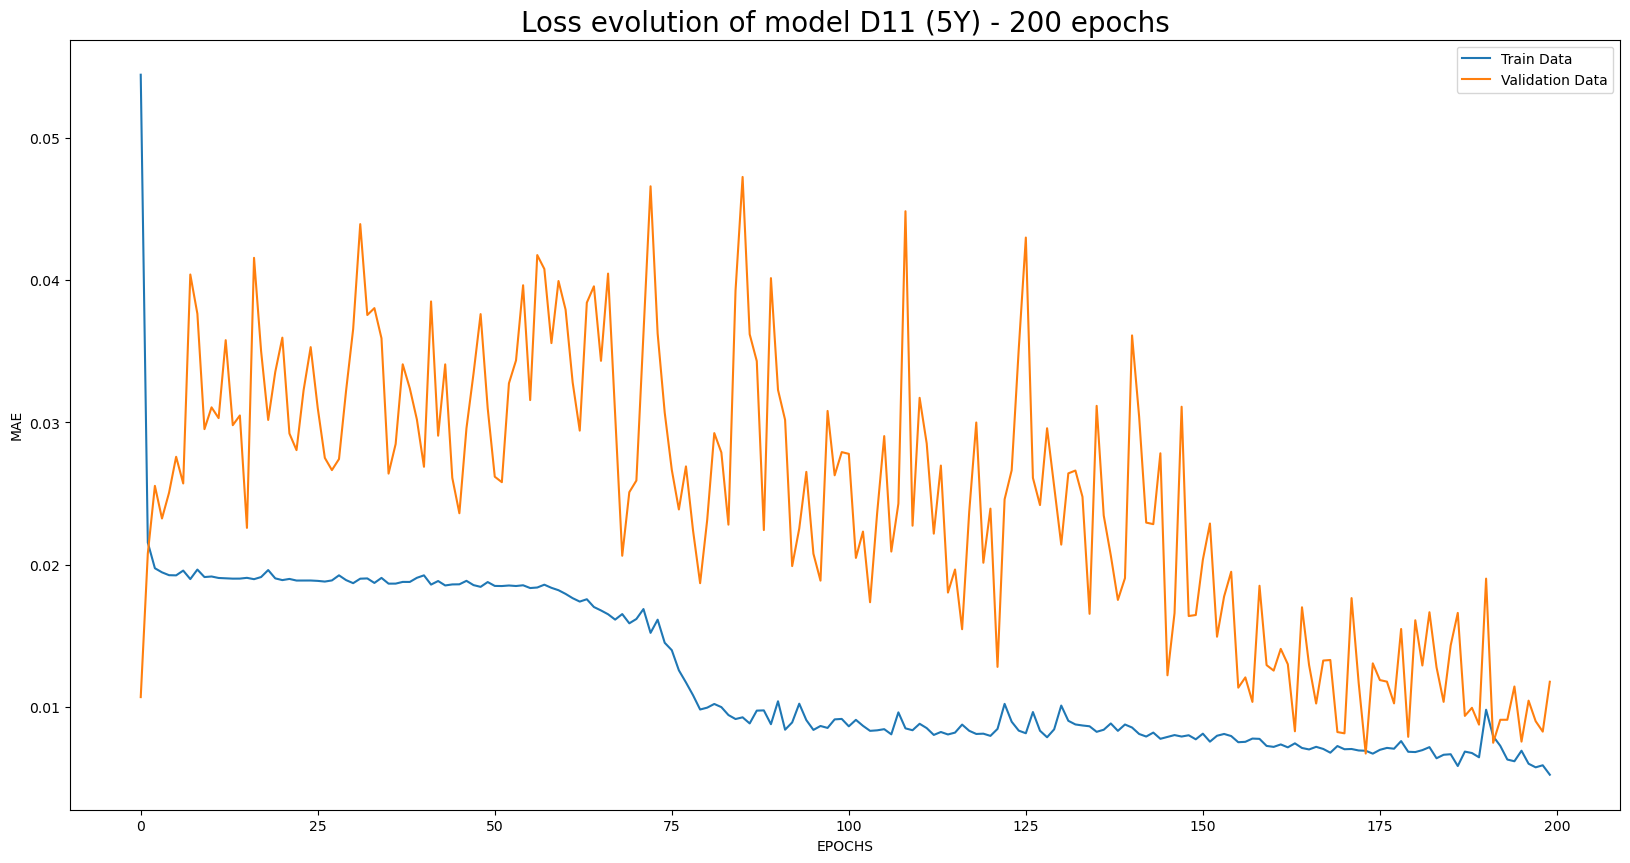

In [40]:
plotHistory(history, title="Loss evolution of model D21 (5Y) - 200 epochs")

## Multiple Stocks model

#### This model predicts the PSI-20 index based on the information from the last 90 days of the PSI-20 AND another stock exchange

In [63]:
df, df_other = load_multiple_index(end_date="2022-08-05")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2018-05-04,5493.379883,5511.290039,5485.919922,5487.790039,57870500,0,0
2018-05-07,5513.689941,5531.500000,5506.319824,5527.759766,59076900,0,0
2018-05-08,5510.660156,5539.560059,5480.609863,5539.560059,116329700,0,0
2018-05-09,5557.060059,5568.930176,5542.729980,5550.390137,89739500,0,0
2018-05-10,5569.100098,5576.879883,5533.459961,5559.620117,62554800,0,0
...,...,...,...,...,...,...,...
2022-08-01,6119.830078,6149.959961,6082.200195,6096.990234,53516500,0,0
2022-08-02,6097.430176,6111.910156,6045.080078,6079.370117,48875100,0,0
2022-08-03,6077.959961,6081.450195,6024.359863,6030.100098,46510500,0,0
2022-08-04,6049.290039,6073.939941,6018.959961,6035.879883,49172400,0,0


In [64]:
df_other

,Open,High,Low,Close,Volume,Dividends,Stock Splits
2018-05-04,5495.709961,5516.049805,5485.990234,5516.049805,85333000,0,0
2018-05-07,5511.939941,5532.120117,5503.700195,5531.419922,45591900,0,0
2018-05-08,5523.910156,5529.149902,5496.390137,5521.930176,70214400,0,0
2018-05-09,5520.649902,5535.240234,5511.580078,5534.629883,72894200,0,0
2018-05-10,5532.370117,5547.200195,5522.910156,5545.950195,48972800,0,0
...,...,...,...,...,...,...,...
2022-08-01,6447.180176,6484.080078,6434.120117,6436.859863,64439900,0,0
2022-08-02,6424.680176,6429.049805,6381.430176,6409.799805,66079400,0,0
2022-08-03,6404.100098,6475.540039,6398.990234,6472.060059,78438000,0,0
2022-08-04,6476.720215,6555.709961,6475.049805,6513.390137,75071500,0,0


In [66]:
#FOREIGN DATA

# Cleans unwanted columns leaving only index and close value
global_data_f, size_train_data_f = selectData(type='univariate', datframe=df_other) 

#Divides the data in train_data and test_data
train_data_f,test_data_f = divideData(global_data_f, size_train_data_f)

#Scales the data
scaler_f=MinMaxScaler(feature_range=(0,1))
scaled_train_data_f=scaleData(train_data_f,scaler_f)

#PSI-20 DATA

# Cleans unwanted columns leaving only index and close value
global_data_p, size_train_data_p = selectData(type='univariate', datframe=df) 

#Divides the data in train_data and test_data
train_data_p,test_data_p = divideData(global_data_p, size_train_data_p)

#Scales the data
scaler_p=MinMaxScaler(feature_range=(0,1))
scaled_train_data_p=scaleData(train_data_p,scaler_p)



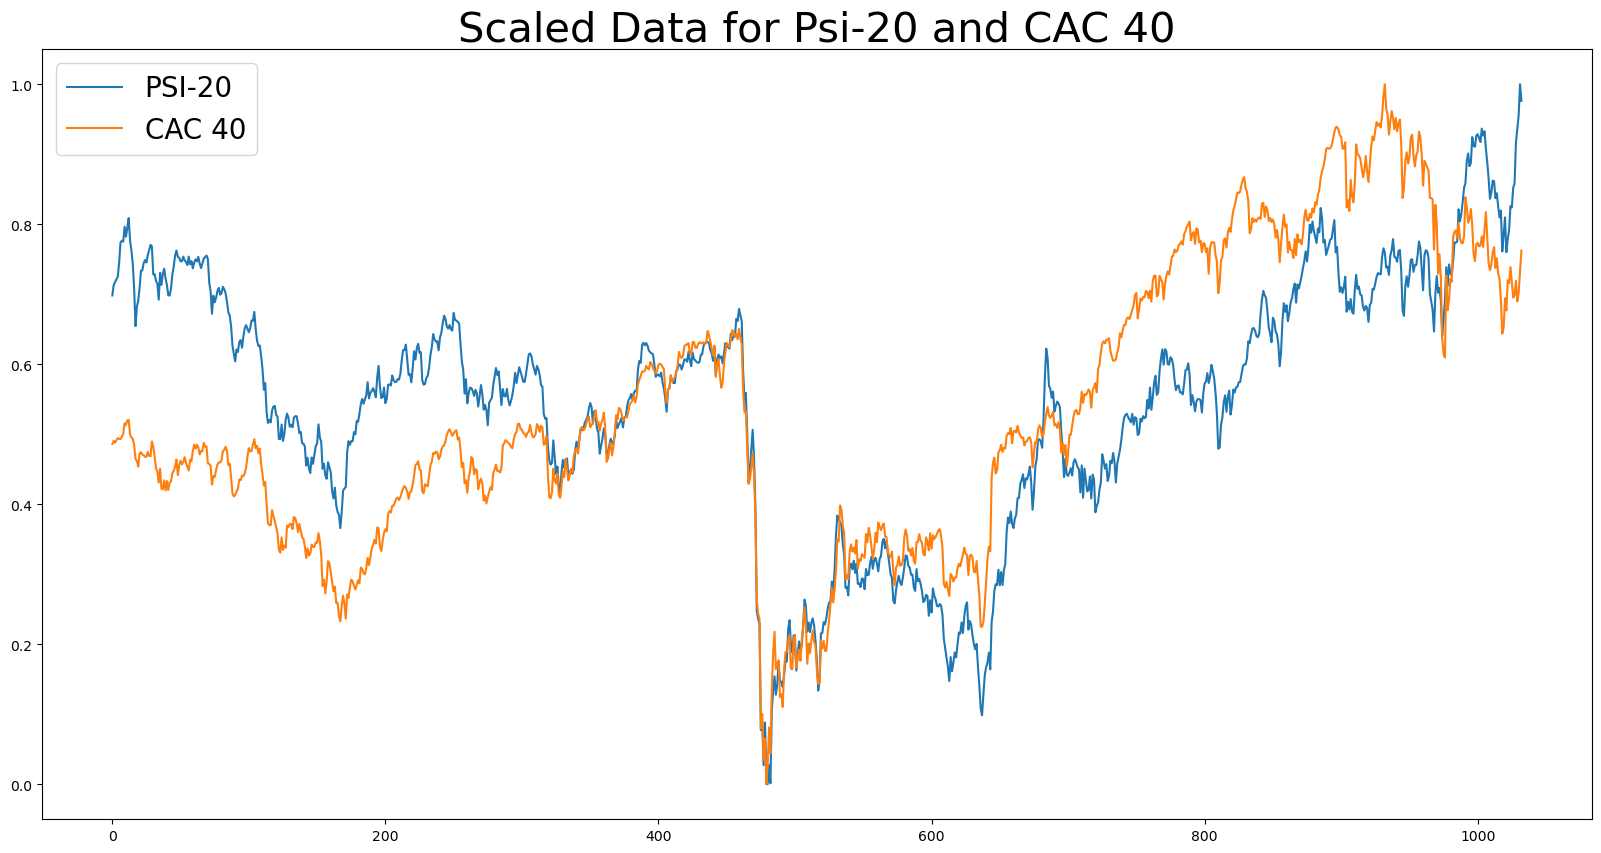

In [67]:
plt.plot(scaled_train_data_p, label='PSI-20')
plt.plot(scaled_train_data_f, label=NAME_FOREIGN)
#plt.plot(y_train_data, label='y_target')
#plt.xlabel("Years")
#plt.ylabel("Stock index value")
plt.title("Scaled Data for Psi-20 and "+ NAME_FOREIGN, fontsize=30)
plt.legend(fontsize=20)
plt.show()


# Prediction

##### Prediction Benchmark

In [79]:

def generateBenchmark(data=global_data,size=size_train_data): #%% Day - Before Prediction function
        day_before_price=data.iloc[size-1:].copy()
        day_before_price_copy = day_before_price.copy()


        for i in range(1,day_before_price.size): 
                day_before_price['Close'][i] = day_before_price_copy['Close'][i-1].copy()

        return day_before_price.iloc[1:]


##### Evaluate Predictions:

In [80]:
def testPredictionsScore(data=test_data, type=""):
    
    if (type=="categorical"):
        data = data[LOOK_BACK+1:,0]
    else:
        data = data[LOOK_BACK:,0]
 

    print('==================================')
    testScore = np.sqrt(mean_squared_error(data, predicted_stock_price))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [81]:
## TO check if necessary (only for fopreign becaus of lookback)
def testPredictionsScore_f(actual=test_data, type="", predicted=""):
    
    print('==================================')
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    print('Test Score: %.2f RMSE' % (testScore))
    print('==================================')    

In [92]:
def testDayBeforeScore(actual, predicted):
    
    #testScore = np.sqrt(mean_squared_error(global_data.iloc[size_train_data:], day_before_price['Close']))
    testScore = np.sqrt(mean_squared_error(actual, predicted))
    #predicted.to_numpy()

    print('==================================')
    print('Test Score Day before: %.2f RMSE' % (testScore))
    print('==================================')

#### Plotting the results

In [83]:
def fillDataForPlotting (history,predicted,benchmark): 
    #Setting Vectors for plotting
    tr_data = history.iloc[:size_train_data]
    tt_data = history.iloc[size_train_data:]
    tt_data = tt_data.assign(Predictions=predicted)
    tt_data = tt_data.assign(Day_Before=benchmark)
    return tr_data,tt_data

In [84]:
def plotAllHistory (train_data,test_data,title): 
    #Plotting all history
    plt.plot(train_data["Close"], label='Historical Data')
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    #plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - All history", fontsize=25)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Index',fontsize=15)
    plt.legend(fontsize=15)
    plt.show()  

In [85]:
def plotPredictedPeriod (train_data,test_data, title):
    #Plot predicted Period
    plt.plot(test_data["Close"], label='Observed Values', color="blue")
    plt.plot(test_data["Predictions"], label='Predicted Values', color="orange")
    plt.plot(test_data["Day_Before"], label='Previous day', color="green")
    plt.title(title + " - Predicted Period", fontsize=25)
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Index',fontsize=15)
    plt.legend(fontsize=15)
    plt.show()  


In [86]:
def plotResults(history=global_data, predicted="",benchmark="", title=""):
    tr_data,tt_data = fillDataForPlotting(history,predicted,benchmark);
    plotAllHistory(tr_data,tt_data, title);
    plotPredictedPeriod(tr_data,tt_data,title);


### Running Predictions

##### Linear Model

In [43]:
#Linear model
day_before_price = generateBenchmark(global_data,size_train_data)
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


2/2 [==============================] - 1s 14ms/step


In [44]:
testPredictionsScore()


Test Score: 83.01 RMSE


In [47]:

testDayBeforeScore(global_data.iloc[size_train_data:], day_before_price)


Test Score Day before: 42.33 RMSE


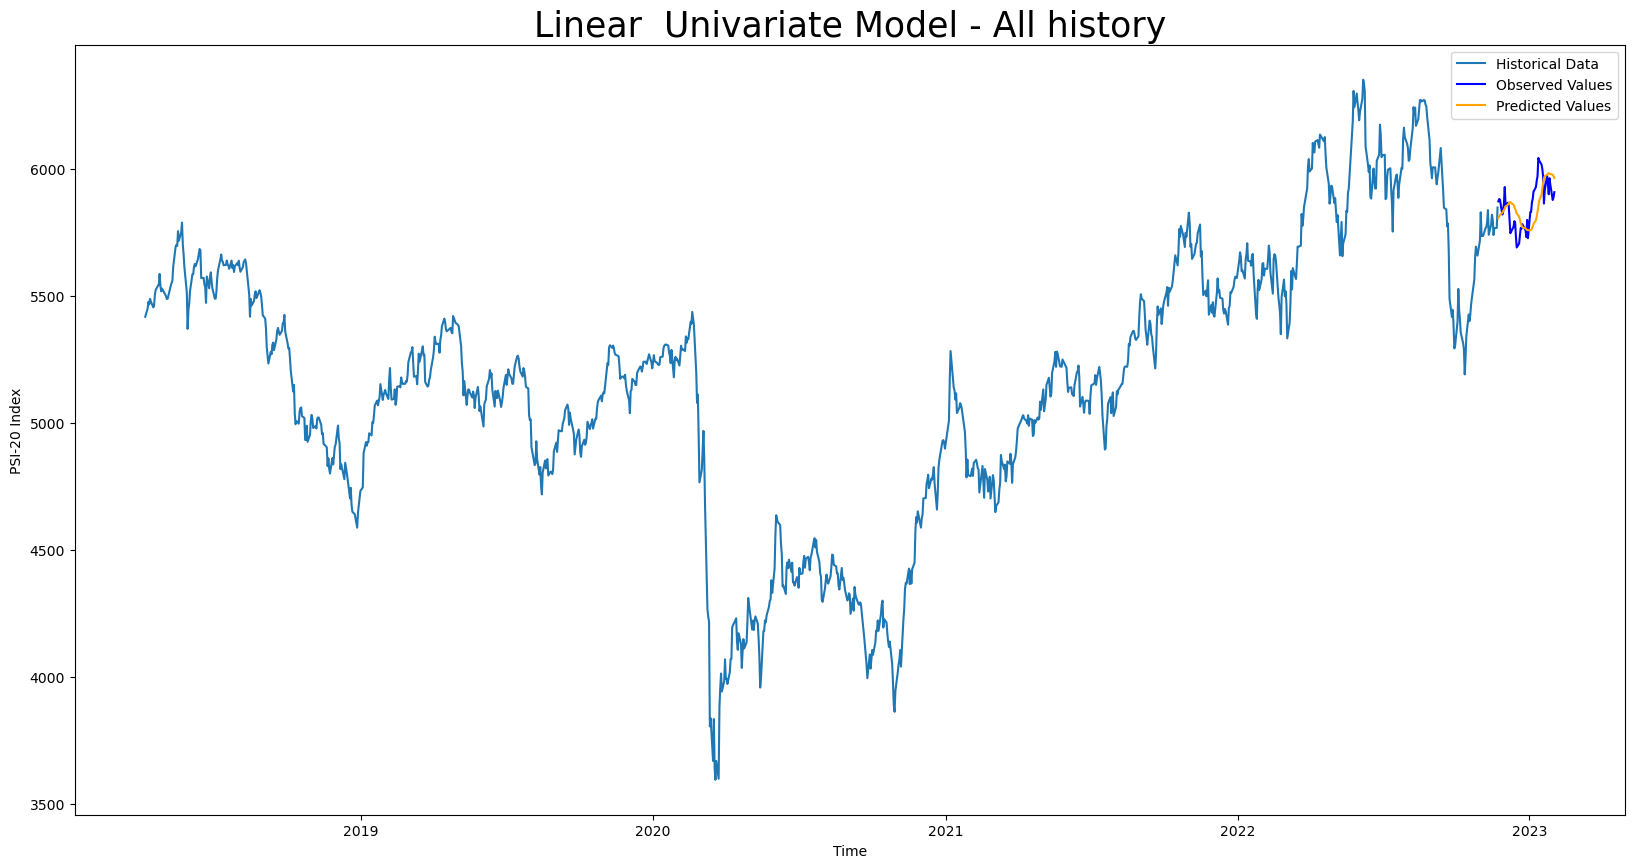

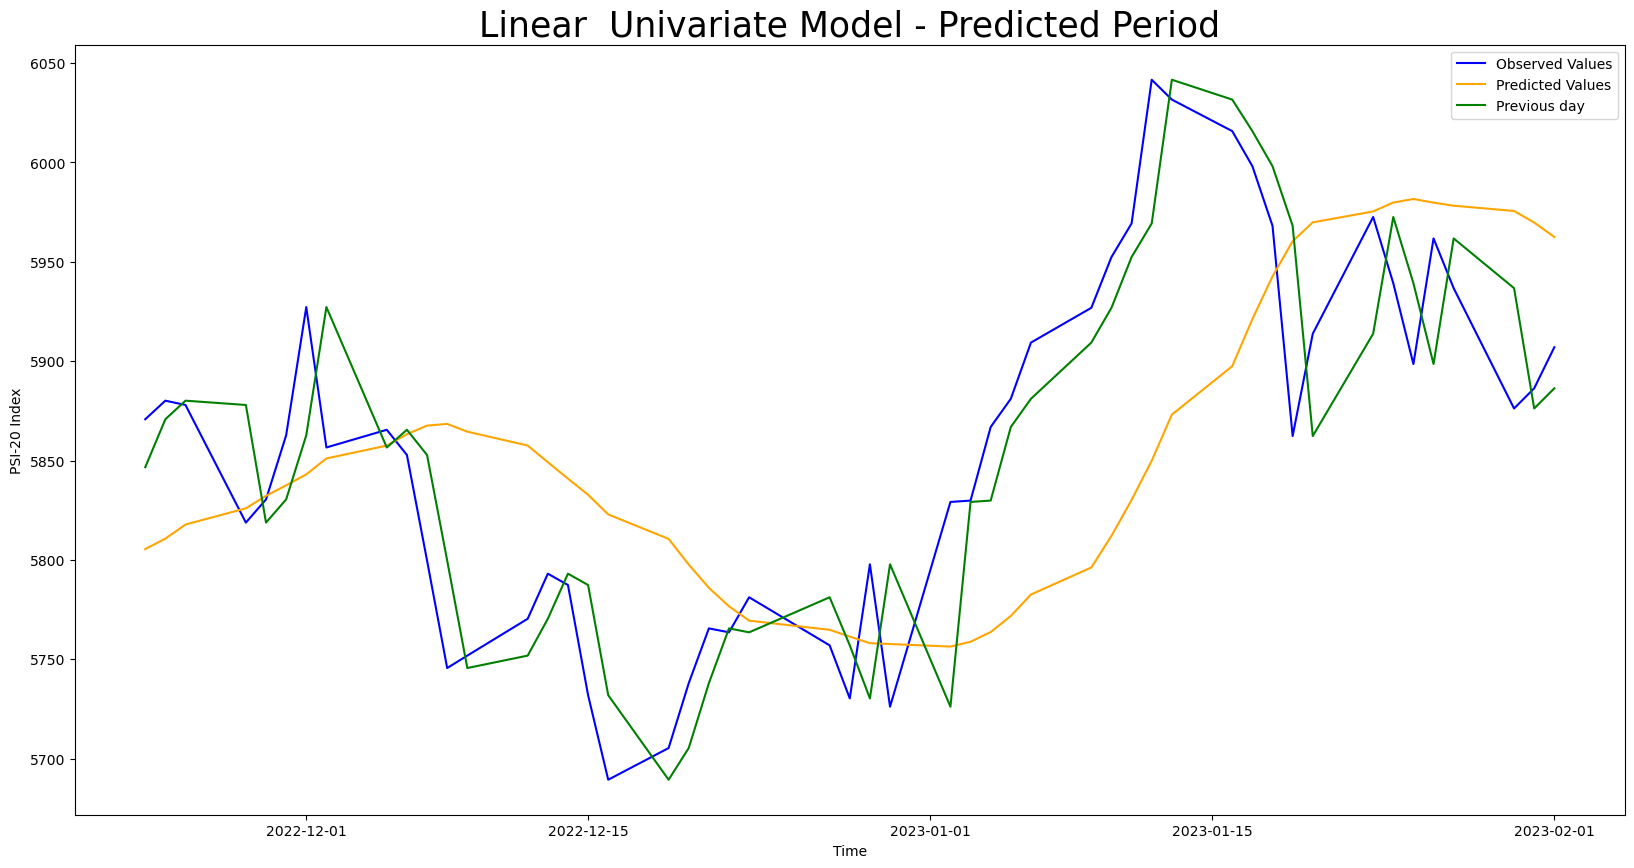

In [49]:
plotResults(predicted=predicted_stock_price,benchmark=day_before_price, title="Linear  Univariate Model")

##### BivariateModel

In [163]:
#Bivariate model
predicted_stock_price=lstm_biv_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)


2/2 [==============================] - 1s 13ms/step


In [164]:
testPredictionsScore()


Test Score: 72.74 RMSE


In [165]:
#TODO this is not working need to first fen
day_before_price = generateBenchmark(data=global_data.drop(['Volume'], axis=1))


In [166]:

testDayBeforeScore(predicted=day_before_price, actual=test_data[LOOK_BACK:,0])

Test Score Day before: 42.33 RMSE


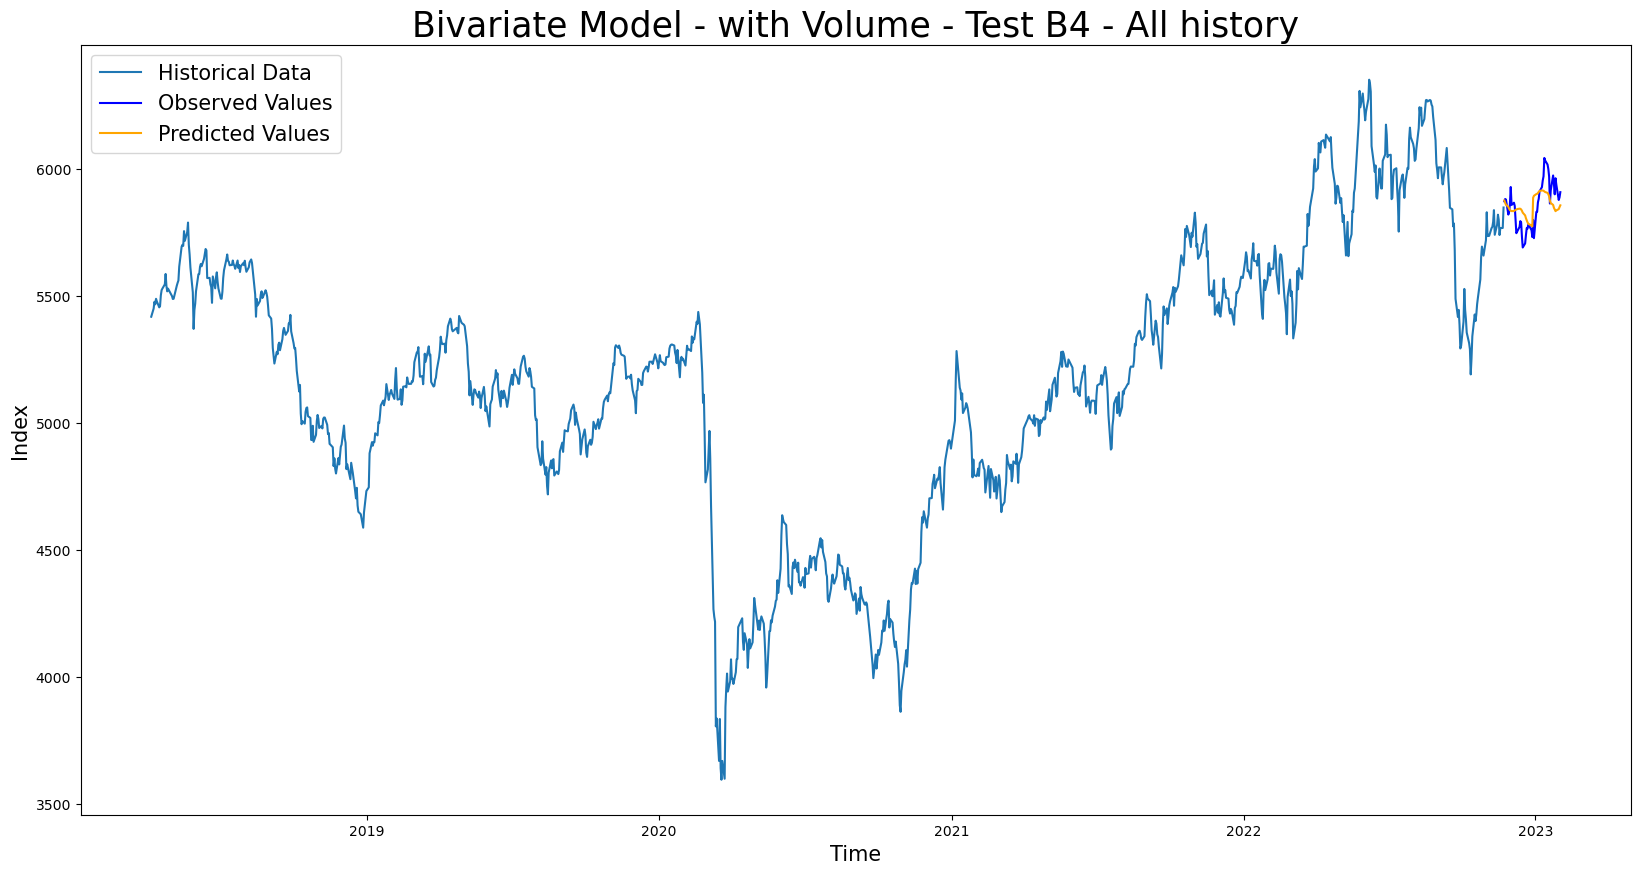

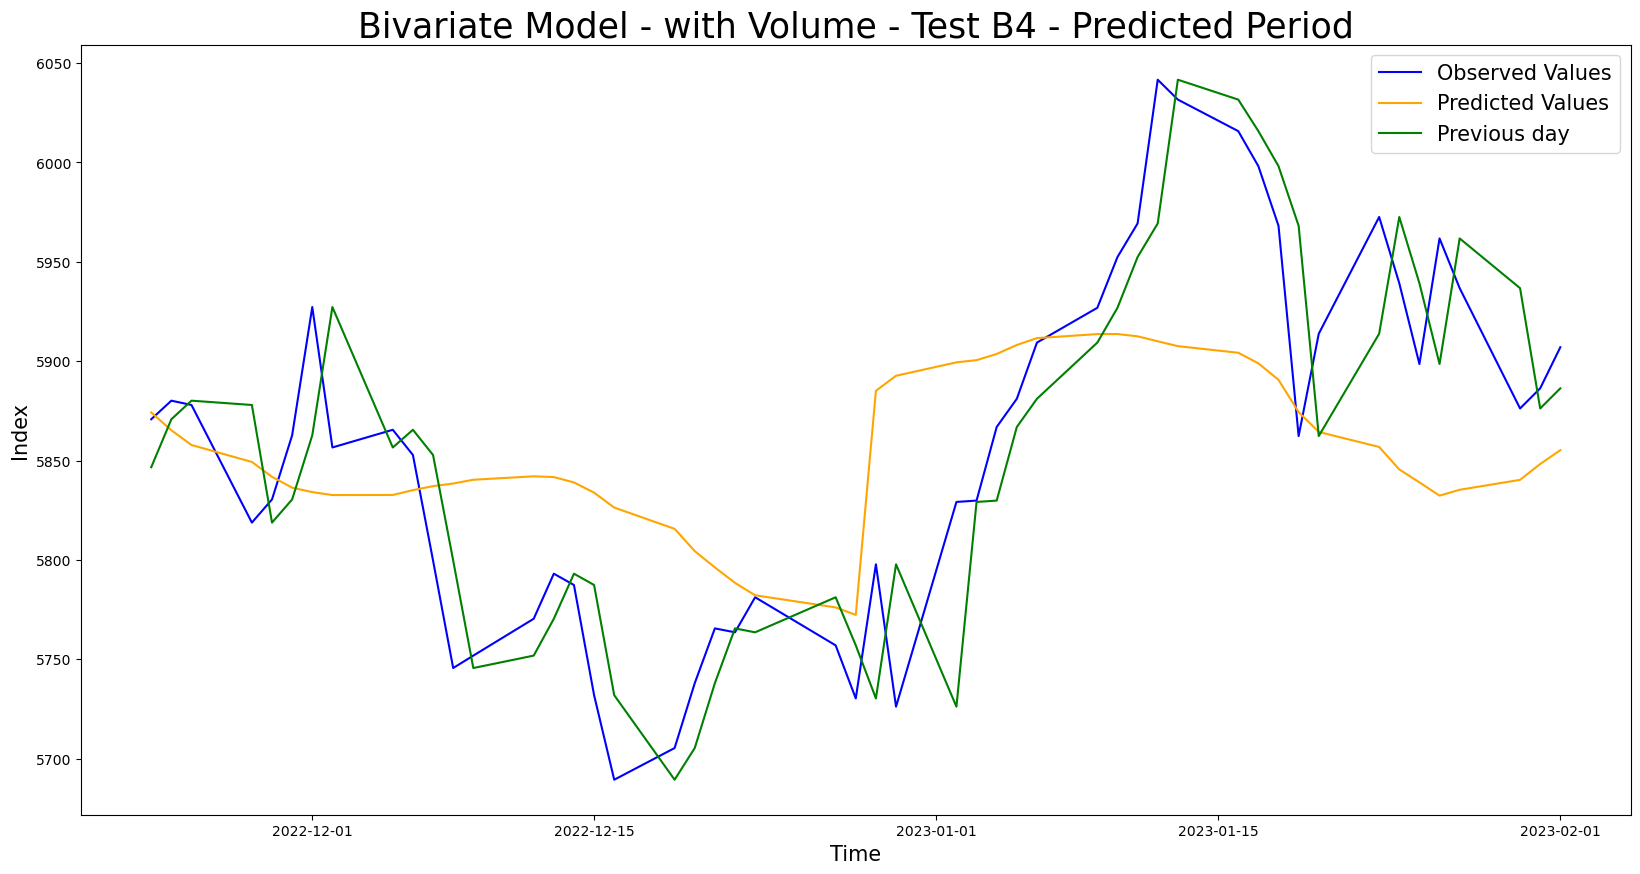

In [167]:
plotResults(history=global_data.drop(['Volume'], axis=1),predicted=predicted_stock_price,benchmark=day_before_price, 
            title="Bivariate Model - with Volume - Test B4")



##### DiffLog Model

In [ ]:
#Difflog Model
predicted_stock_price=lstm_difflog_model.predict(X_test)

2/2 [==============================] - 1s 26ms/step


In [ ]:
testPredictionsScore(scaled_test_data)
#testDayBeforeScore()

Test Score: 0.01 RMSE


##### Classification Model

In [132]:
#Category Model
predicted_stock_cat=lstm_class_model.predict(X_test)
print("Test C2")

2/2 [==============================] - 0s 14ms/step
Test C2


In [128]:
y_train_data[:,0].sum()
y_train_data[:,2].sum()

782.0

In [133]:

predictions=np.argmax(predicted_stock_cat, axis=1)
observations =  np.argmax(Y_test, axis=1)

In [134]:
#print(predicted_stock_cat)
from sklearn.metrics import accuracy_score

print(predictions)
print(len(predictions))

print(observations)
print(len(observations))

accuracy_score(observations, predictions)
##testPredictionsScore("categorical")




[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
49
[1 1 0 1 2 2 0 1 1 0 0 1 2 2 1 0 0 1 2 2 1 2 0 0 2 0 2 1 2 1 2 1 2 1 2 1 1
 0 0 0 2 2 0 0 2 0 0 1 2]
49


0.32653061224489793

In [135]:
import matplotlib.pyplot as plt
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(observations, predictions)
#cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Decrease", "stable", "Increase"])
confusion_matrix




array([[ 0, 16,  0],
       [ 0, 16,  0],
       [ 0, 17,  0]], dtype=int64)

<AxesSubplot: title={'center': '"C2" Heatmap'}>

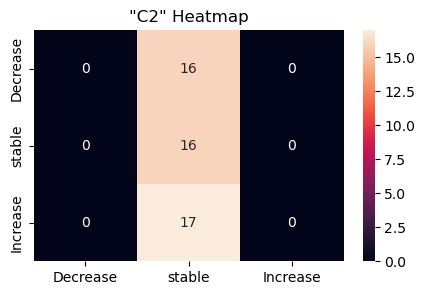

In [136]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix, index = ["Decrease", "stable", "Increase"],
                  columns = ["Decrease", "stable", "Increase"])
plt.figure(figsize = (5,3))
plt.title('"C2" Heatmap')
sn.heatmap(df_cm,annot=True)

In [48]:
#PARA ELIMINAR
#Making a list with the actual index value variations.

# Selecting the 50 last values and logging
test_data_log = np.log(test_data[90:])
test_data_diff = test_data_log[0:49,]

# iterating the log array and returing the diff to the test_data_diff array
for i in range (len(test_data_log)-1) :
    test_data_diff[i] = test_data_log[i+1] - test_data_log[i]

observed = test_data_diff.T[0]

#test_obs = createTargetClassVector(test_data, numCat=3)

print(observed)





[ 0.00687009 -0.02464646  0.00703873 -0.00556887  0.00748891 -0.0091929
 -0.00117877  0.01700666  0.01035396 -0.00979701  0.00154599 -0.00550967
 -0.00059742 -0.00811545 -0.00267264  0.00334654 -0.00141261 -0.01003748
  0.01213823  0.00151957  0.00978227 -0.00042272  0.00432562  0.00466847
  0.00246244 -0.00050781 -0.00039313  0.01221177  0.00575506 -0.00313871
 -0.01008848  0.00068237 -0.00578652  0.01324648  0.00394317  0.00740367
 -0.01221573 -0.00035669 -0.00297521  0.00751704  0.00061986 -0.01443652
 -0.02785462 -0.00384202  0.0210215   0.00695686 -0.00725022  0.00766546
  0.01094032]


#### Linear with foreign data

In [92]:
#gets the values from previous day as a benchmark
day_before_price = generateBenchmark(global_data_p,size_train_data)

# the model makes its predictiona (scaled data)
predicted_stock_price=lstm_model.predict(X_test)


2/2 [==============================] - 1s 13ms/step


In [93]:

#We (un)scale the data back.
pred=scaler_p.inverse_transform(predicted_stock_price)

In [94]:
testPredictionsScore_f(actual=test_data_p, predicted=pred)
testDayBeforeScore(test_data_p,day_before_price)

Test Score: 1651.22 RMSE
Test Score Day before: 75.02 RMSE


In [ ]:
plt.plot(predicted_stock_price, label='Predicted')
plt.plot(scaled_train_data_p, label='actual')
plt.plot(scaled_train_data, label='NYSE')
plt.xlabel("Years", fontsize=15)
plt.ylabel("Stock index value")
plt.title("The Psi-20 and "+NAME_FOREIGN, fontsize=20)
plt.legend(fontsize=15)
plt.show()

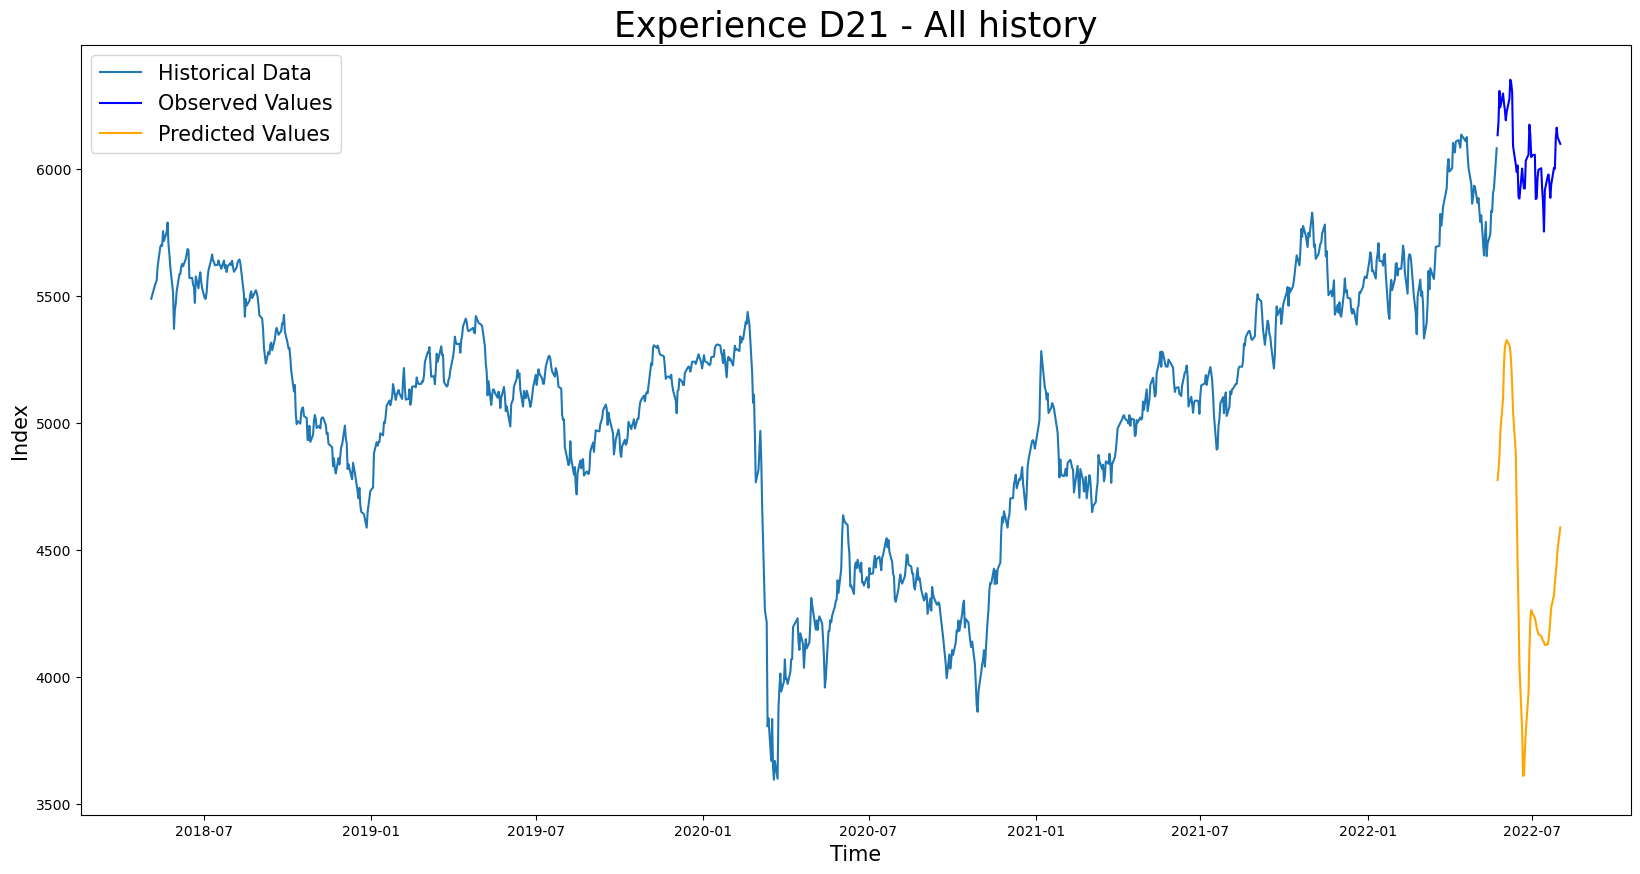

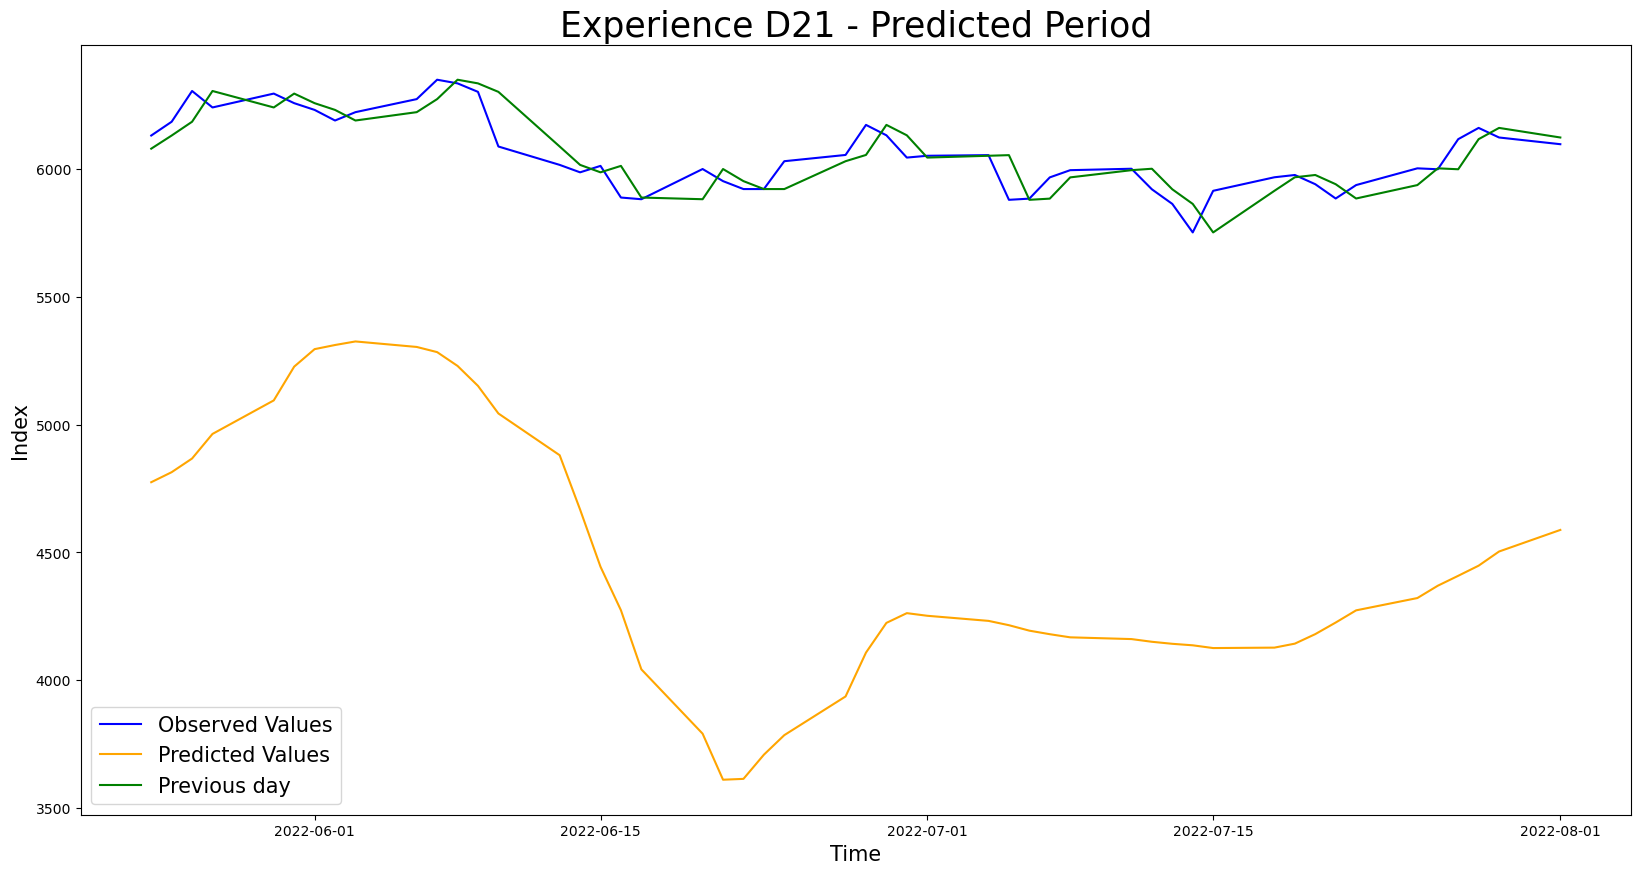

In [96]:
plotResults(history=global_data_p, predicted=pred,benchmark=day_before_price,title="Experience D21")



## Clear All

In [204]:
globals().clear

<function dict.clear>